# Cat or Dog Image Classifier

This notebook is my atempt at implementing my first image classifier, i was inspierd by [this video](https://www.youtube.com/watch?v=cAICT4Al5Ow) and to train the modle i used [Dogs vs. Cats dataset](https://www.kaggle.com/c/dogs-vs-cats) from [Kaggle](https://www.kaggle.com). The implemented modle is an AlexNet and i got its implementation from [tflearn examples](https://github.com/tflearn/tflearn/blob/master/examples/images/alexnet.py), i only tweaked it to mach the dataset.
<div style ="justify-content: center;">
    <figure  style="float:left;margin-right:5px;" >
       <img src="http://www.freepngimg.com/thumb/cat/7-cat-png-image-download-picture-kitten-thumb.png" alt="cat" width="200" height="200">
       <figcaption>Fig1. - A cat.</figcaption>
    </figure>
    <figure  style="float:left;margin-right:5px;">
       <img src="http://www.freepngimg.com/thumb/dog/24-dog-png-image-picture-download-dogs-thumb.png" alt="dog" width="200" height="200">
       <figcaption>Fig2. - A dog.</figcaption>
    </figure>
</div>

___
## Imports

Nothing fancy here most of the imports are standard and frequent in ML

In [1]:
import h5py                     #handeling the dataset
import matplotlib.pyplot as plt #viewing nparrays as images
import numpy as np
import os                       #handeling files and folders
import random
import requests
import string
import tensorflow as tf
import tflearn as tfl

#Layers used in the model
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression

#used to import images as nparrays
from PIL import Image


/home/mrlipdx/Documents/ml/tensorflowGPU/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


___
## Some constants

This is to improve modularity and code redability

In [2]:
MODEL_NAME = "tflearn_AlexNet"

#Folder Constants
#where data is stored
DATA_PATH = "/media/mrlipdx/F88A16BB8A1675FA/Users/MrLipdx/ml"
#where the images from the dataset are
IMAGE_FOLDER = os.path.join(DATA_PATH, "train")
#where to save the HDF5 files
HDF5_FOLDER = os.path.join(DATA_PATH, "hdf5")
#where to save the trainde modle
MODELS_FOLDER = os.path.join(DATA_PATH, "model")
#where the current modle is located
MODEL_FOLDER = os.path.join(MODELS_FOLDER, MODEL_NAME)

#File Path Constants
#Where to load or save the modle to
MODEL_FILE = os.path.join(MODEL_FOLDER, MODEL_NAME)
#text file describing the train dataset
HDF5_TRAIN_INPUT = os.path.join(HDF5_FOLDER, "cats_and_dogs_train.txt")
#train hdf5 file
HDF5_TRAIN = os.path.join(HDF5_FOLDER, "cats_and_dogs_train.hdf5")
#text file describing the test dataset 
HDF5_TEST_INPUT = os.path.join(HDF5_FOLDER, "cats_and_dogs_test.txt")
#test hdf5 file
HDF5_TEST = os.path.join(HDF5_FOLDER, "cats_and_dogs_test.hdf5")

#The ids given to cats and dogs
CLASS_IDS = { "c" : 0, "d" : 1 }

#size of the images in the dataset
IMAGE_SHAPE = (296,299)
#total number of images test + train
TOTAL_IMAGES = len(os.listdir(IMAGE_FOLDER))
#how much test percentage do we want from the total images
TEST_PERCENTAGE = 0.2
TRAIN_PERCENTAGE = 1 - TEST_PERCENTAGE
TEST_SIZE = int(TOTAL_IMAGES * TEST_PERCENTAGE)
TRAIN_SIZE = TOTAL_IMAGES - TEST_SIZE

#True if you want to train a new network
#False if you want to load a previously trainded network
TRAIN = False

#make shure the notebook is consistent after multiple runs
np.random.seed(42)

___
## Data

I'm using a hdf5 database as input on the model. The data is manualy partitioned to a test set and a traning set. The creation of the databases takes a bit of time and at the end uses 26,6 GB so we will save it to save time in the future.

In [3]:
#formats the filenames to the requierd form, "<filepath> <class>\n"
def filenames_to_input(filenames, directory , class_ids):
    return "".join(['{} {}\n'.format(
            os.path.join(directory, filename), class_ids[filename[0]])
            for filename in filenames])

if not os.path.exists(HDF5_FOLDER): 
    os.makedirs(HDF5_FOLDER)
    
if not os.path.isfile(HDF5_TEST) or not os.path.isfile(HDF5_TRAIN):
    print("Missing one or both datasets.")
    print("Creating datasets...")
    images = np.array(os.listdir(IMAGE_FOLDER))
    
    #spliting the images to a train and a test sets
    np.random.shuffle(images)
    test_images = images[:TEST_SIZE]
    train_images = images[TEST_SIZE:]
    
    if not os.path.isfile(HDF5_TEST):
        print("\tCreating test HDF5 dataset...") 
        with open(HDF5_TEST_INPUT, "w") as test_input_file:
            test_input_file.write(filenames_to_input(test_images, IMAGE_FOLDER, CLASS_IDS))

        tfl.data_utils.build_hdf5_image_dataset(HDF5_TEST_INPUT, 
                                            image_shape = IMAGE_SHAPE,
                                            output_path = HDF5_TEST,
                                            categorical_labels = True)
        print("\tDone.\n")

    if not os.path.isfile(HDF5_TRAIN):
        print("\tCreating train HDF5 dataset...")  
        with open(HDF5_TRAIN_INPUT, "w") as train_input_file:
            train_input_file.write(filenames_to_input(train_images, IMAGE_FOLDER, CLASS_IDS))

        tfl.data_utils.build_hdf5_image_dataset(HDF5_TRAIN_INPUT, 
                                            image_shape = IMAGE_SHAPE,
                                            output_path = HDF5_TRAIN,
                                            categorical_labels = True)
        print("\tDone.")
    print("Done.")
else:
    print("Both datasets present.")
    
test_dataset = h5py.File(HDF5_TEST, 'r')
x_test = test_dataset['X']
y_test = test_dataset['Y']
train_dataset = h5py.File(HDF5_TRAIN, 'r')
x_train = train_dataset['X']
y_train = train_dataset['Y']

Both datasets present.


___
## Building the model
Now comes the fun part creating a model to learn to classify our dataset, using tflear makes it easy and realy simple to compeend the general idea of the model.

In [4]:
network = input_data(shape=[None, IMAGE_SHAPE[1], IMAGE_SHAPE[0], 3])
network = conv_2d(network, 96, 11, strides=4, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 256, 5, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 2, activation='softmax')
network = regression(network, optimizer='momentum',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


___
## Traning
Traning the model takes a bit of time in my case i used my Nvidia GTX 1060 and it still took me 2 H or so. I'm not sure why but it kept crashing because me SO was running out of memory and killing the process. If you have anny idea as to why this is happening please let me know.

In [5]:
model = tfl.DNN(network, checkpoint_path = MODEL_FILE,
                max_checkpoints = 1, tensorboard_verbose = 0)

if TRAIN:
    #when it traning craches i use the following lines to resume from a chekpoint
    #in this case the traning crashed after step 800
    #CHEKPOINT = "-800"
    #model.load(MODEL_FILE + CHEKPOINT, weights_only = True)
    #print("Model Loaded, evaluating ...")
    #print(model.evaluate(x_test, y_test))
    model.fit(x_train, y_train, n_epoch = 20, validation_set = (x_test, y_test),
           snapshot_step = 200, show_metric = True, run_id = MODEL_NAME)
    model.save(MODEL_FILE)
else:
    print("Skiping Traning, using previous model.")
    model.load(MODEL_FILE,  weights_only = True)
    
train_dataset.close()

Skiping Traning, using previous model.
INFO:tensorflow:Restoring parameters from /media/mrlipdx/F88A16BB8A1675FA/Users/MrLipdx/ml/model/tflearn_AlexNet/tflearn_AlexNet


___
## Testing
Here are some functions to test the model
predict uses images from the test set
cassify can acces images from urls

In [6]:
def name_from_array(arr):
    if arr[0] > arr[1]:
        return 'cat'
    else:
        return 'dog'

def predict(i):
    '''From a given index i the function will show :
    the image in the index
    the models prediction
    the correct awnser'''
    img = x_test[i]
    plt.imshow(img)
    predicted_name = name_from_array(model.predict(x_test[i:i+1])[0])
    expected_name = name_from_array(y_test[i])
    
    print("I think it's a {}..".format(predicted_name))
    if predicted_name == expected_name :
        print("I was right it is a {}".format(expected_name))
    else:
        print("I was wrong it's actualy a {}".format(expected_name))

I think it's a dog..
I was right it is a dog


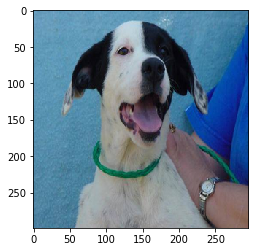

In [7]:
predict(200)

I think it's a dog..
I was wrong it's actualy a cat


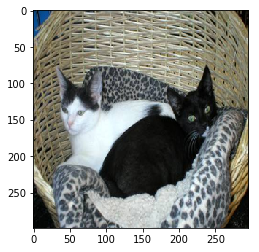

In [8]:
predict(2)

As we can see it's not perfect but it't good enough.

In [9]:
def classify(link):
    """Classifies if an image from a given url has a dog or a cat."""
    #random name for the file
    filename = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(8))
    #downloading the image
    with open(filename, 'wb') as file: 
        file.write(requests.get(link, allow_redirects=True).content)
    #opening the image
    img = Image.open(filename)
    #deleting the image from the file sistem
    os.remove(filename)
    #resizing the image to the network input size
    #removing the alpha layer it it has one
    #normalizing rgb from [0, 255] to [0, 1]
    img = np.asarray(img.resize((296,299)))[:,:,:3] / 255
    plt.imshow(img)
    prediction = model.predict([img])[0]
    predicted_name = name_from_array(prediction)
    print("I think it's a {}..".format(predicted_name))


I think it's a cat..


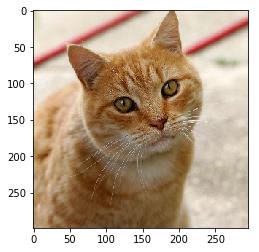

In [10]:
classify("https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg")

___
## Conclusion
This was a fun winter break project and im glad i made it, i learned about image manipulation, image classification and machine learnign. There are aspects that can be improved, the modle could do with more traning, and some code could be clener. Anny feedback is apreciated. Feel free to ask anny questions.